# Image detection using custom dataset

Importing the required packages and libraries

In [ ]:
pip install tqdm

In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [ ]:
# Assigning class names

In [63]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

# Loading the Data
Define a load_data function that load the images and the labels from the folder.

In [ ]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images 
    """

    datasets = ['./seg_train/seg_train', './seg_test/seg_test']
    output = []
    
    # Iterate training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the imgage
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


# Exploring the data set
No of training and testing examples
Size of each image and proportion of each observed category


In [70]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


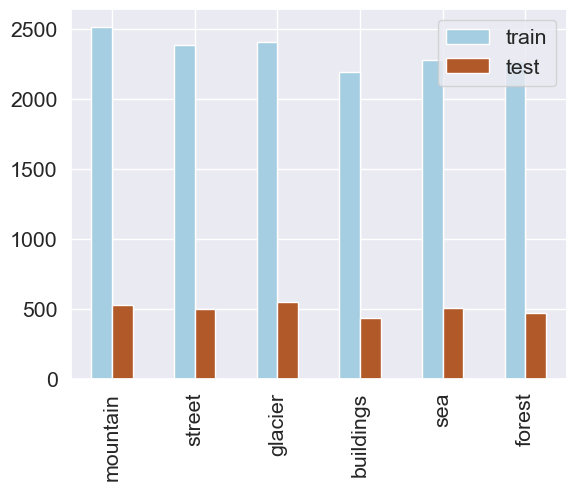

In [82]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar(colormap="Paired")
plt.show()

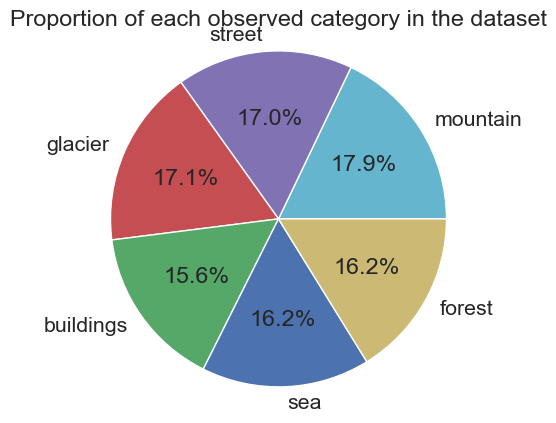

In [95]:
colors=['c','m','r','g','b','y']
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,colors=colors,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category in the dataset')
plt.show()

##  scale the data

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [28]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

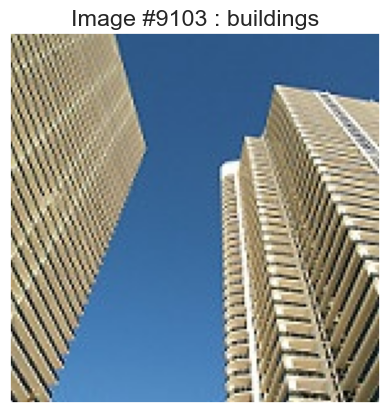

In [29]:
display_random_image(class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the datasets", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

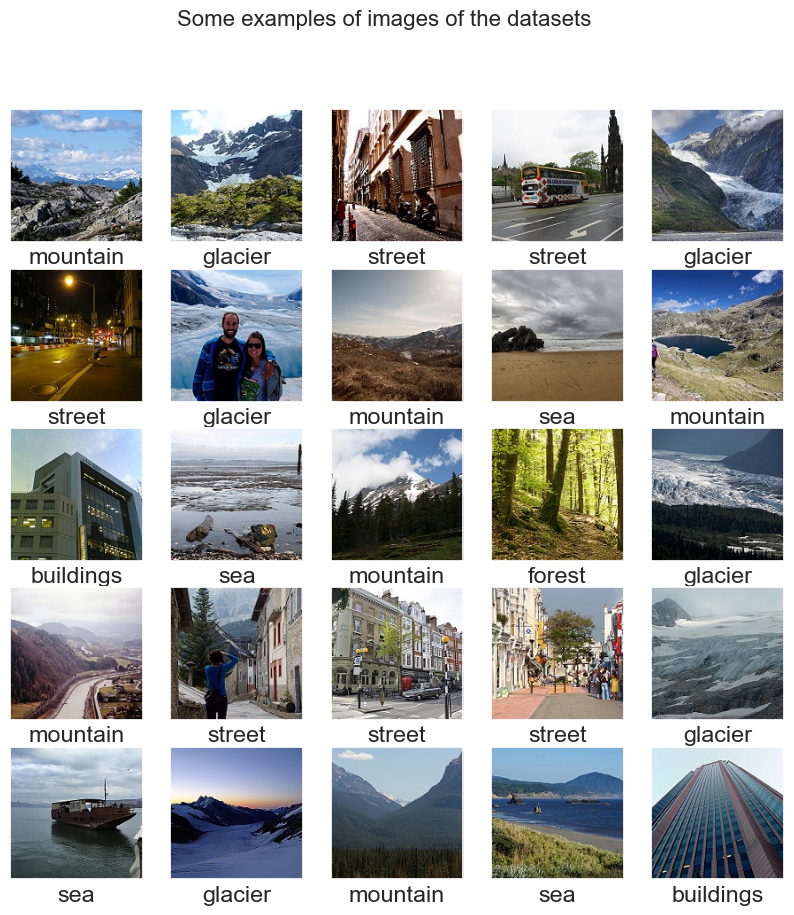

In [16]:
display_examples(class_names, train_images, train_labels)

# Model Creation

Steps are:
1. Model Building,
2. Model Compiling,
3. Train / fit the data to the model,
4. Evaluate the model on the testing set,
5. Error analysis of our model.

Layers:
 Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
 MaxPooling2D: The images get half sized.
 Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
 Relu  : given a value x, returns max(x, 0).
 Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then compile it with some parameters such as:
    Optimizer: adam = RMSProp + Momentum.
    Momentum = takes into account past gradient to have a better update.
    RMSProp = exponentially weighted average of the squares of past gradients.
    Loss function:  use sparse categorical crossentropy for classification, each images belongs to one class only

In [18]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [19]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=5, validation_split = 0.2)

Epoch 1/5
88/88 [==============================] - 237s 3s/step - loss: 1.2061 - accuracy: 0.5555 - val_loss: 0.8881 - val_accuracy: 0.6587
Epoch 2/5
88/88 [==============================] - 267s 3s/step - loss: 0.7561 - accuracy: 0.7245 - val_loss: 0.7423 - val_accuracy: 0.7211
Epoch 3/5
88/88 [==============================] - 251s 3s/step - loss: 0.6098 - accuracy: 0.7852 - val_loss: 0.6687 - val_accuracy: 0.7510
Epoch 4/5
88/88 [==============================] - 251s 3s/step - loss: 0.4770 - accuracy: 0.8320 - val_loss: 0.6981 - val_accuracy: 0.7499
Epoch 5/5
88/88 [==============================] - 226s 3s/step - loss: 0.3612 - accuracy: 0.8767 - val_loss: 0.6645 - val_accuracy: 0.7709


In [67]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

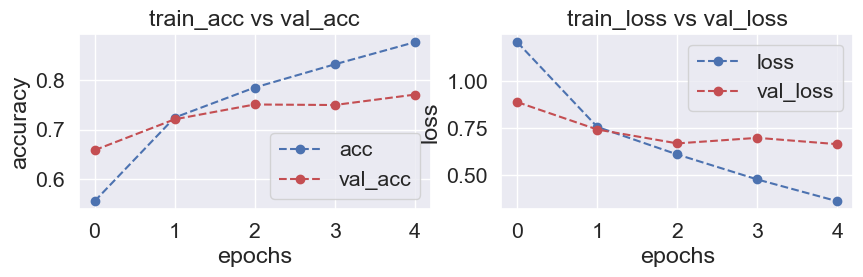

In [25]:
plot_accuracy_loss(history)

In [26]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 9s 90ms/step - loss: 0.6890 - accuracy: 0.7607


94/94 [==============================] - 6s 67ms/step


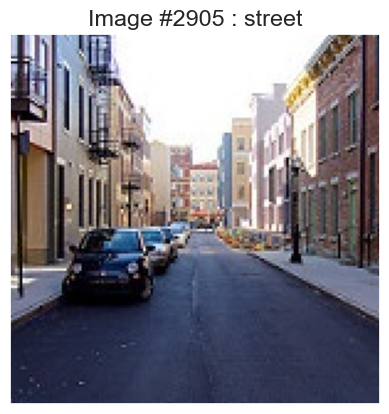

In [30]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [31]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


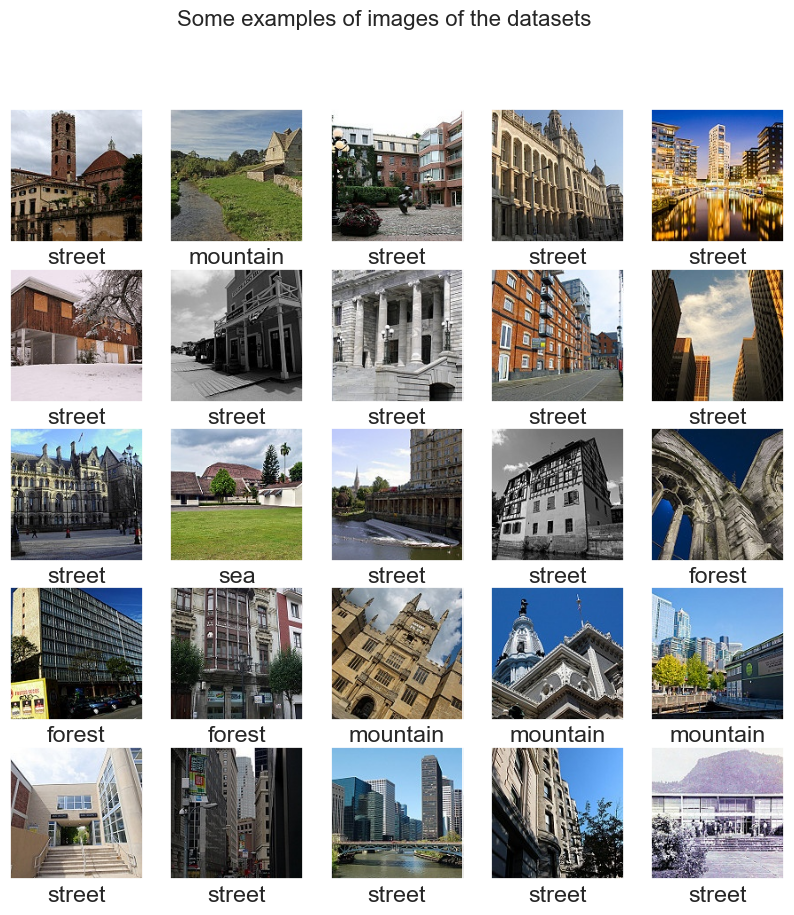

In [32]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

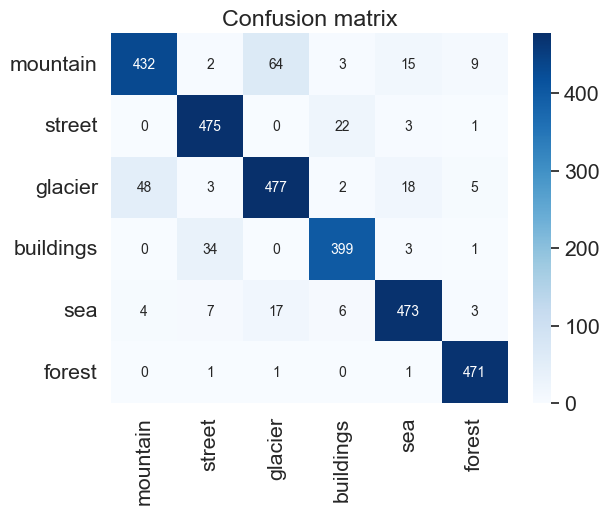

In [97]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,cmap="Blues",fmt='g', 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. It can be understandable as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for to fully distinguish them.
However, it can detects forest very accurately!


Feature extraction with VGG16 trained on ImageNet

Ensemble models of Neural Networks with the features extracted from VGG

Fine Tuning with VGG16 trained on ImageNet

# Feature extraction with VGG ImageNet

In [34]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 15s 0us/step


Get the features directly from VGG16

In [36]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 191s 2s/step


## Visualize the features through PCA

In [38]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [39]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

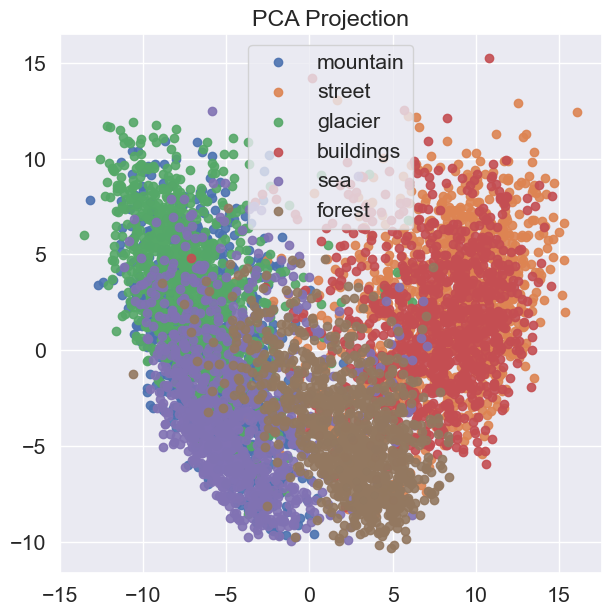

In [108]:
### Figures

plt.subplots(figsize=(7,7))
for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.9)
plt.legend()
plt.title("PCA Projection")
plt.show()

The clusters correspond more or less to the labels.

glacier and mountain points are very close to each other, as VGG sees them as very similar.

There is no distinction between building and street.
 

## Training on top of VGG

Train a simple one-layer Neural Network on the features extracted from VGG.

In [41]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 3s 23ms/step - loss: 0.5599 - accuracy: 0.7913 - val_loss: 0.3548 - val_accuracy: 0.8639
Epoch 2/15
88/88 [==============================] - 1s 8ms/step - loss: 0.3140 - accuracy: 0.8876 - val_loss: 0.3321 - val_accuracy: 0.8732
Epoch 3/15
88/88 [==============================] - 1s 8ms/step - loss: 0.2621 - accuracy: 0.9071 - val_loss: 0.3441 - val_accuracy: 0.8750
Epoch 4/15
88/88 [==============================] - 1s 8ms/step - loss: 0.2150 - accuracy: 0.9262 - val_loss: 0.3347 - val_accuracy: 0.8807
Epoch 5/15
88/88 [==============================] - 1s 8ms/step - loss: 0.1864 - accuracy: 0.9368 - val_loss: 0.3420 - val_accuracy: 0.8799
Epoch 6/15
88/88 [==============================] - 1s 8ms/step - loss: 0.1595 - accuracy: 0.9477 - val_loss: 0.3253 - val_accuracy: 0.8846
Epoch 7/15
88/88 [==============================] - 1s 9ms/step - loss: 0.1327 - accuracy: 0.9577 - val_loss: 0.3289 - val_accuracy: 0.8892
Epoch 8/15
88/88 [=

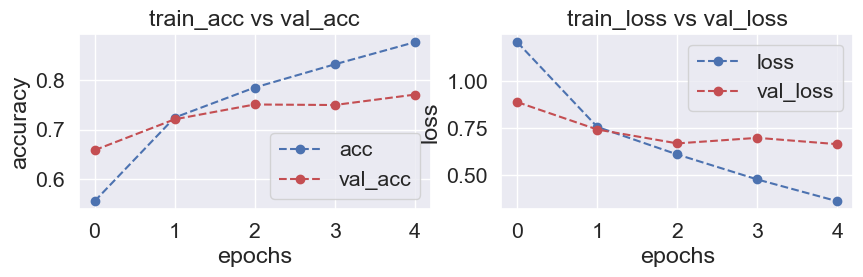

In [42]:
plot_accuracy_loss(history)

In [43]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.4003 - accuracy: 0.8780


# Ensemble Neural Networks

In [44]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

Define n_estimators Neural Networks. 

Each Neural Network will be trained on random subsets of the training dataset. Each subset contains max_samples samples.

In [45]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [46]:
histories = []

for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
79/79 [==============================] - 1s 11ms/step - loss: 0.5337 - accuracy: 0.8007 - val_loss: 0.3131 - val_accuracy: 0.8949
Epoch 2/10
79/79 [==============================] - 1s 11ms/step - loss: 0.2523 - accuracy: 0.9145 - val_loss: 0.2411 - val_accuracy: 0.9118
Epoch 3/10
79/79 [==============================] - 1s 10ms/step - loss: 0.1839 - accuracy: 0.9405 - val_loss: 0.2199 - val_accuracy: 0.9163
Epoch 4/10
79/79 [==============================] - 1s 10ms/step - loss: 0.1441 - accuracy: 0.9565 - val_loss: 0.1931 - val_accuracy: 0.9368
Epoch 5/10
79/79 [==============================] - 1s 10ms/step - loss: 0.1062 - accuracy: 0.9702 - val_loss: 0.1899 - val_accuracy: 0.9412
Epoch 6/10
79/79 [==============================] - 1s 9ms/step - loss: 0.0872 - accuracy: 0.9779 - val_loss: 0.1727 - val_accuracy: 0.9466
Epoch 7/10
79/79 [==============================] - 1s 10ms/step - loss: 0.0673 - accuracy: 0.9839 - val_loss: 0.1728 - val_accuracy: 0.9484
Epoch 8/10
79/

In [47]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 2ms/step


In [48]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8896666666666667


# Fine Tuning VGG ImageNet

In [49]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [50]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 176s 2s/step


In [51]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [52]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0   

In [54]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 277s 3s/step - loss: 0.6915 - accuracy: 0.7261 - val_loss: 0.3989 - val_accuracy: 0.8646
Epoch 2/10
88/88 [==============================] - 262s 3s/step - loss: 0.3196 - accuracy: 0.8847 - val_loss: 0.3278 - val_accuracy: 0.8792
Epoch 3/10
88/88 [==============================] - 1127s 13s/step - loss: 0.2570 - accuracy: 0.9109 - val_loss: 0.2997 - val_accuracy: 0.8910
Epoch 4/10
88/88 [==============================] - 261s 3s/step - loss: 0.2200 - accuracy: 0.9229 - val_loss: 0.2805 - val_accuracy: 0.8974
Epoch 5/10
88/88 [==============================] - 264s 3s/step - loss: 0.1788 - accuracy: 0.9393 - val_loss: 0.3219 - val_accuracy: 0.8935
Epoch 6/10
88/88 [==============================] - 266s 3s/step - loss: 0.1476 - accuracy: 0.9462 - val_loss: 0.3469 - val_accuracy: 0.9035
Epoch 7/10
88/88 [==============================] - 266s 3s/step - loss: 0.1314 - accuracy: 0.9525 - val_loss: 0.3335 - val_accuracy: 0.9010
Epoch 8/10


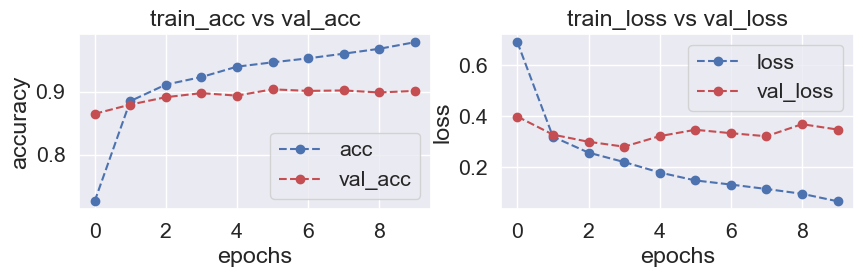

In [55]:
plot_accuracy_loss(history)

In [56]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 14s 149ms/step
Accuracy : 0.909
